In [ ]:
!pip install hmmlearn

     |████████████████████████████████| 374 kB 4.1 MB/s 


In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [ ]:
from hmmlearn import hmm
import matplotlib.pyplot as plt

import numpy as np
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/DA2/

Mounted at /content/drive
/content/drive/MyDrive/DA2


In [ ]:
import pandas as pd 
data = pd.read_csv('ETH-USD.csv')
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Change
0,8/8/2015,2.793760,2.798810,0.714725,0.753325,0.753325,674188,-0.728249
1,8/9/2015,0.706136,0.879810,0.629191,0.701897,0.701897,532170,-0.068268
2,8/10/2015,0.713989,0.729854,0.636546,0.708448,0.708448,405283,0.009333
3,8/11/2015,0.708087,1.131410,0.663235,1.067860,1.067860,1463100,0.507323
4,8/12/2015,1.058750,1.289940,0.883608,1.217440,1.217440,2150620,0.140075
5,8/13/2015,1.222240,1.965070,1.171990,1.827670,1.827670,4068680,0.501240
6,8/14/2015,1.810920,2.261880,1.754750,1.827870,1.827870,4637030,0.000109
7,8/15/2015,1.802890,1.877240,1.570980,1.688900,1.688900,2554360,-0.076028
8,8/16/2015,1.684350,1.695240,1.089810,1.566030,1.566030,3550790,-0.072751
9,8/17/2015,1.581190,1.581190,1.185340,1.203610,1.203610,1942830,-0.231426


In [ ]:
full_len = data.shape[0]
num_val = 360
num_test = 180
num_subtract = 500
num_train = full_len - num_subtract - num_val - num_test
print('Data length = ',full_len - num_subtract)
print('Num train = ',num_train, " Num test = ", num_test, " Num validation = ", num_val)


Data length =  1777
Num train =  1237  Num test =  180  Num validation =  360


In [ ]:
print(data.iloc[500:,:])

            Date         Open         High  ...    Adj Close       Volume    Change
500   12/20/2016     7.633680     7.745900  ...     7.660040      6313550  0.002122
501   12/21/2016     7.663660     7.943600  ...     7.914400      9393550  0.033206
502   12/22/2016     7.899040     7.905860  ...     7.585000     16376700 -0.041620
503   12/23/2016     7.576950     7.691740  ...     7.166150     19613100 -0.055221
504   12/24/2016     7.152420     7.405430  ...     7.265770      7626020  0.013901
...          ...          ...          ...  ...          ...          ...       ...
2272  10/31/2021  4322.744141  4394.449707  ...  4288.074219  17498160238 -0.008687
2273   11/1/2021  4288.217285  4377.322266  ...  4324.626953  17985288261  0.008524
2274   11/2/2021  4322.500977  4599.948242  ...  4584.798828  20794448222  0.060161
2275   11/3/2021  4589.684570  4664.910156  ...  4607.193848  21220463155  0.004885
2276   11/5/2021  4530.326660  4568.064941  ...  4491.558105  16947375104 -0

In [ ]:
market_data = data.iloc[:,1:5].values
print(market_data)

[[2.79376000e+00 2.79881000e+00 7.14725000e-01 7.53325000e-01]
 [7.06136000e-01 8.79810000e-01 6.29191000e-01 7.01897000e-01]
 [7.13989000e-01 7.29854000e-01 6.36546000e-01 7.08448000e-01]
 ...
 [4.32250098e+03 4.59994824e+03 4.28868652e+03 4.58479883e+03]
 [4.58968457e+03 4.66491016e+03 4.46297607e+03 4.60719385e+03]
 [4.53032666e+03 4.56806494e+03 4.47693213e+03 4.49155811e+03]]


In [ ]:
log_market_data = market_data

Text(0.5, 1.0, 'Close price after log')

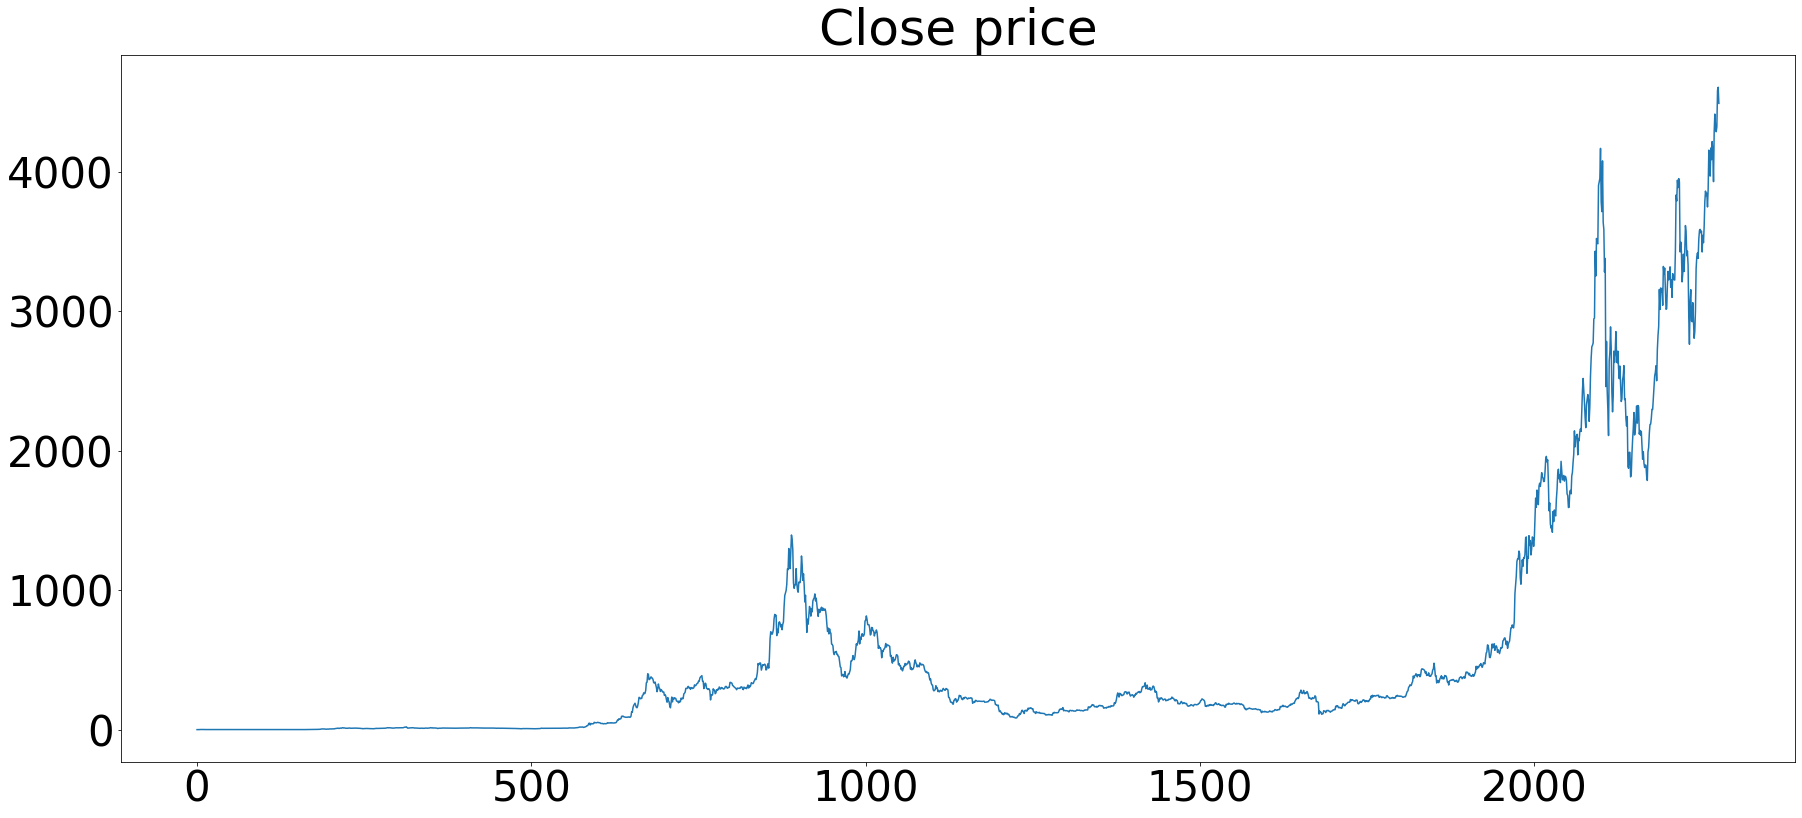

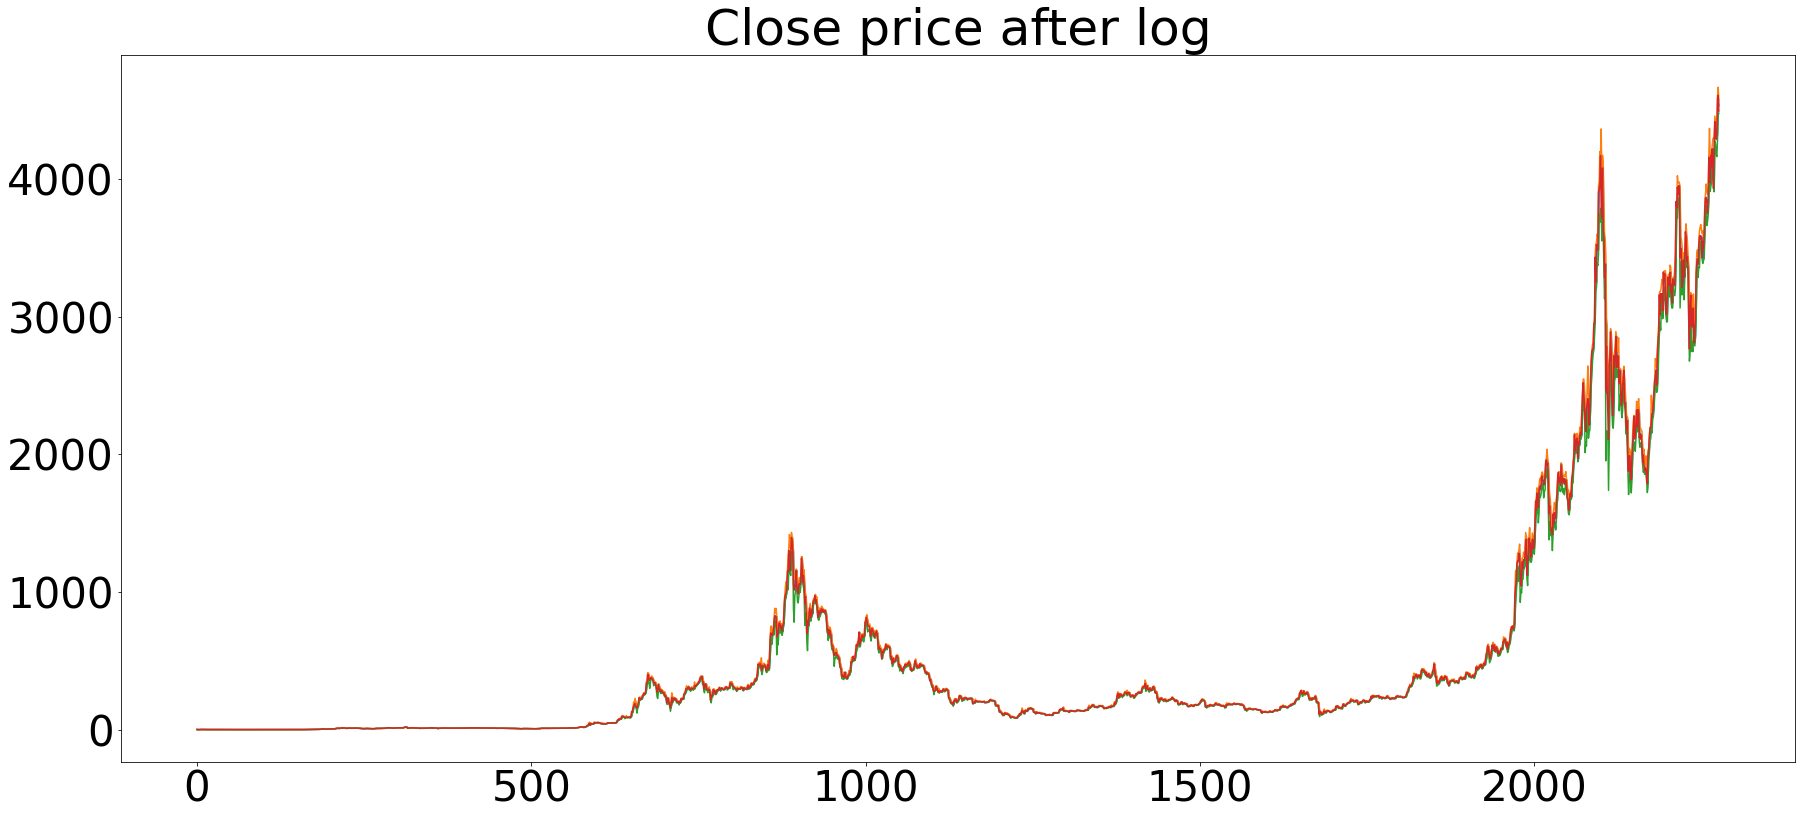

In [ ]:
plt.figure(figsize=(30,13))
plt.plot(list(range(full_len)), market_data[:,3])
plt.title('Close price')
plt.figure(figsize=(30,13))
for i in range(4):
  plt.plot(list(range(full_len)),log_market_data[:,i])
plt.title('Close price after log')


In [ ]:
MA_data = log_market_data[500:,3]
MA5 = []
MA20 = []
MA50 = []
MA100 = []
for i in range (500, full_len):
  MA5.append(np.mean(log_market_data[i-5:i,0]))
  MA20.append(np.mean(log_market_data[i-20:i,0]))
  MA50.append(np.mean(log_market_data[i-50:i,0]))
  MA100.append(np.mean(log_market_data[i-100:i,0]))

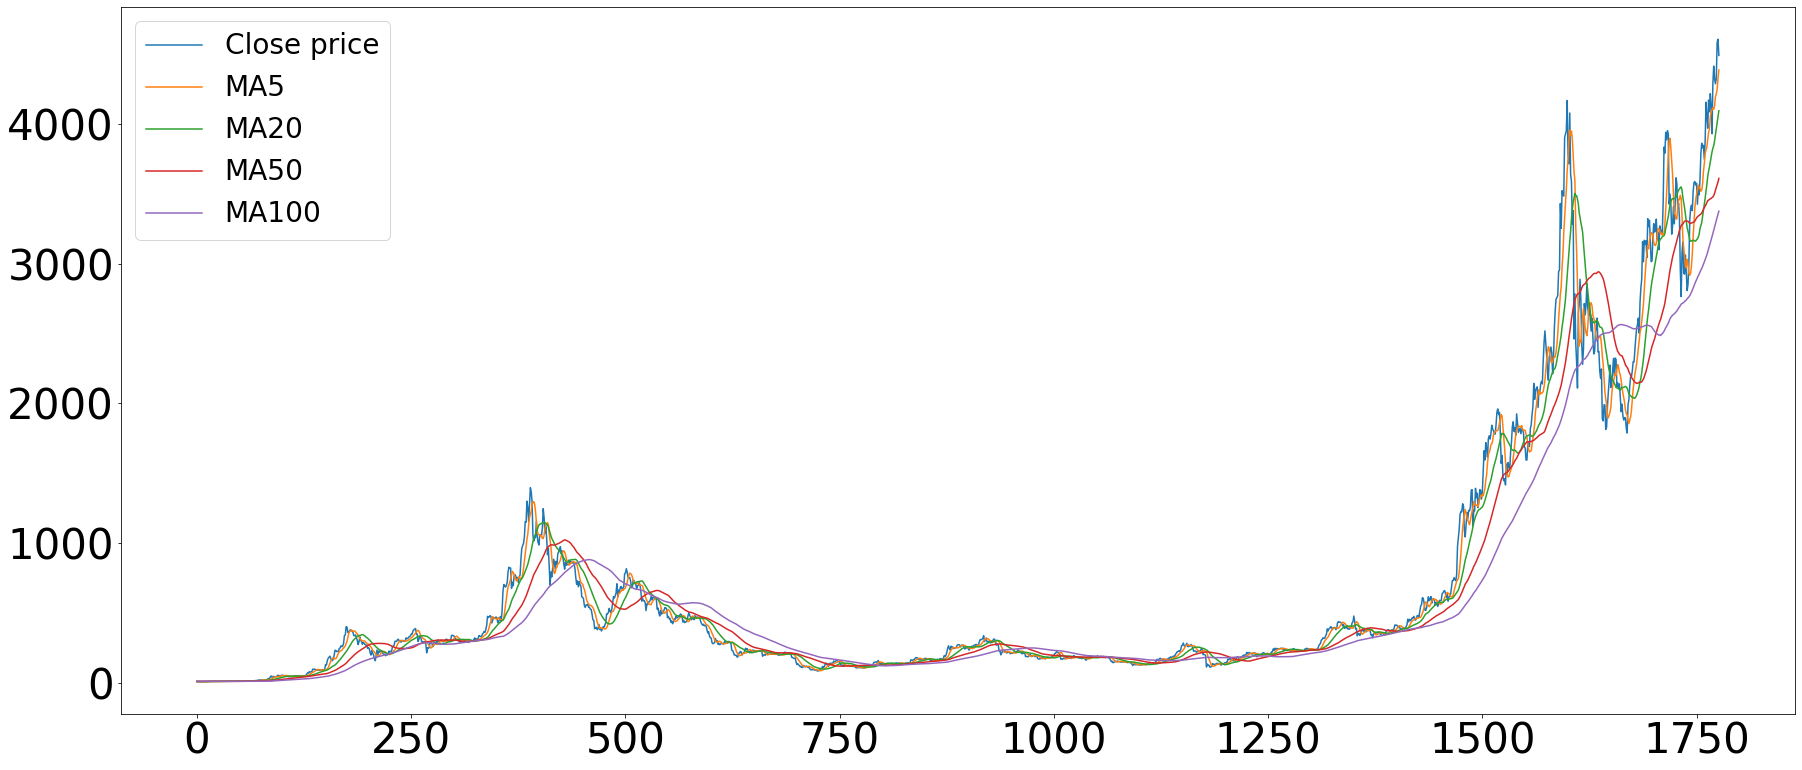

In [ ]:
plt.figure(figsize=(30,13))
plt.plot(list(range(full_len - num_subtract)),MA_data, label = "Close price")
plt.plot(list(range(full_len - num_subtract)),MA5, label = "MA5")
plt.plot(list(range(full_len - num_subtract)),MA20, label = "MA20")
plt.plot(list(range(full_len - num_subtract)),MA50, label = "MA50")
plt.plot(list(range(full_len - num_subtract)),MA100, label = "MA100")
plt.rcParams.update({'font.size': 42})
plt.legend(fontsize = 28)

In [ ]:
volum_change = data.iloc[500:,6:8].values
print(volum_change)

[[ 6.31355000e+06  2.12197600e-03]
 [ 9.39355000e+06  3.32060930e-02]
 [ 1.63767000e+07 -4.16203380e-02]
 ...
 [ 2.07944482e+10  6.01605360e-02]
 [ 2.12204632e+10  4.88462400e-03]
 [ 1.69473751e+10 -2.50989530e-02]]


In [ ]:
def std(X):
  avg = np.mean(X)
  sum = 0
  for i in range(len(X)):
    sum = sum + (X[i] - avg)**2
  return math.sqrt(sum/(len(X)-1))

In [ ]:
STD5 = []
STD20 = []
STD50 = []
STD100 = []
for i in range (500, full_len):
  STD5.append(std(log_market_data[i-5:i,0]))
  STD20.append(std(log_market_data[i-20:i,0]))
  STD50.append(std(log_market_data[i-50:i,0]))
  STD100.append(std(log_market_data[i-100:i,0]))

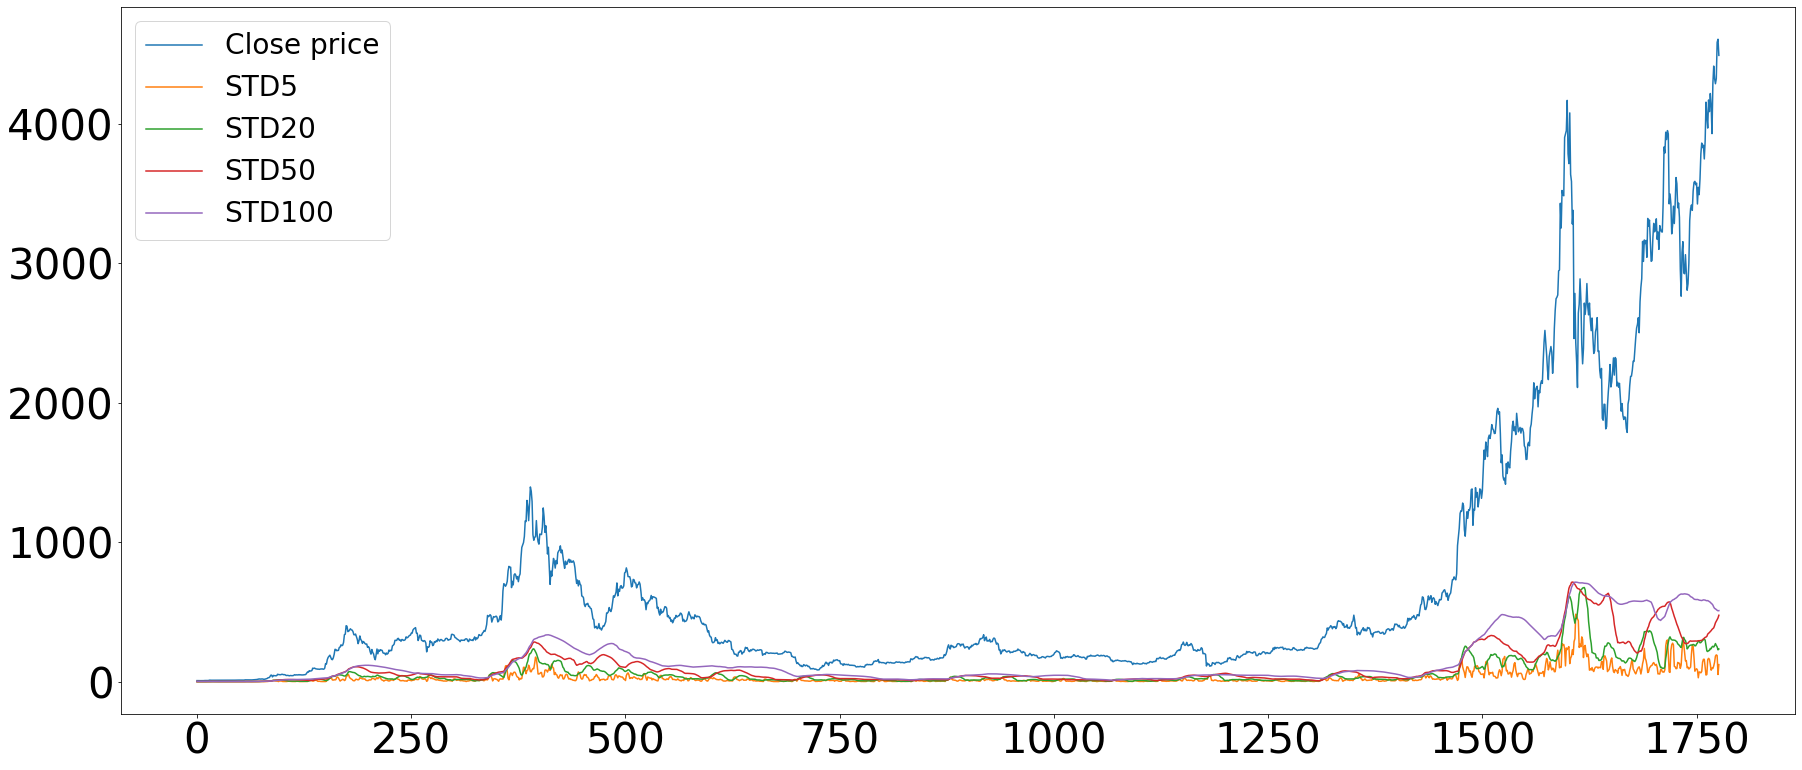

In [ ]:
plt.figure(figsize=(30,13))
plt.plot(list(range(full_len - num_subtract)), MA_data, label = "Close price")
plt.plot(list(range(full_len - num_subtract)), STD5, label = "STD5")
plt.plot(list(range(full_len - num_subtract)), STD20, label = "STD20")
plt.plot(list(range(full_len - num_subtract)), STD50, label = "STD50")
plt.plot(list(range(full_len - num_subtract)), STD100, label = "STD100")
plt.legend(fontsize = 28)

In [ ]:
def calculate_ema(prices, days, smoothing=2):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    return ema

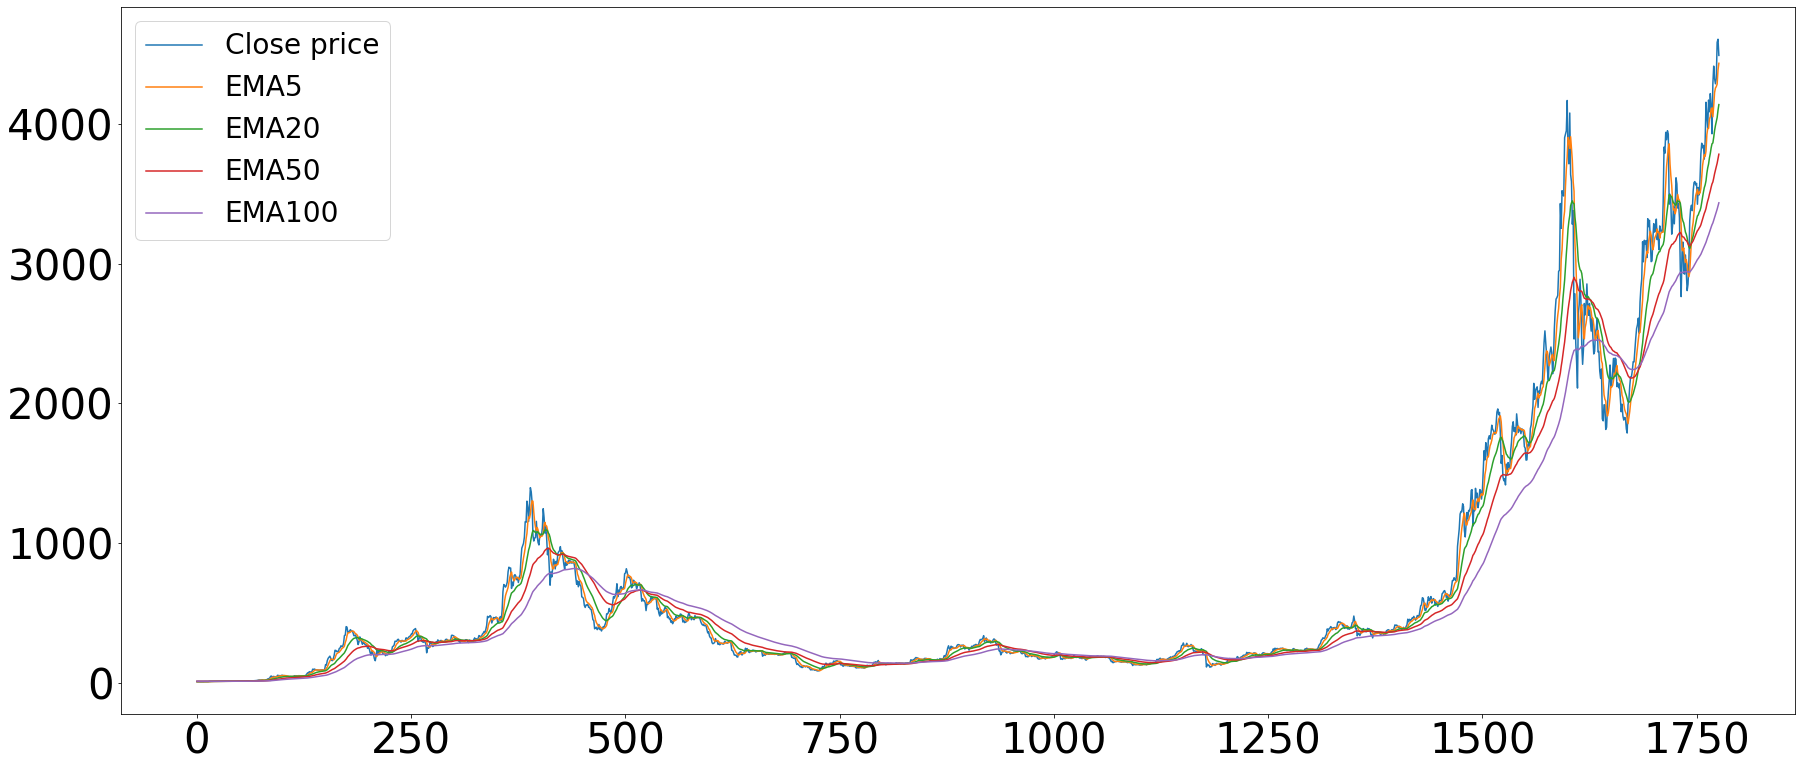

In [ ]:
EMA5 = calculate_ema(log_market_data[500-4:,0],5)
EMA20 = calculate_ema(log_market_data[500-19:,0],20)
EMA50 = calculate_ema(log_market_data[500-49:,0],50)
EMA100 = calculate_ema(log_market_data[500-99:,0],100)

plt.figure(figsize=(30,13))
plt.plot(list(range(full_len - 500)), MA_data, label = 'Close price')
plt.plot(list(range(full_len - 500)), EMA5, label = 'EMA5')
plt.plot(list(range(full_len - 500)), EMA20, label = 'EMA20')
plt.plot(list(range(full_len - 500)), EMA50, label = 'EMA50')
plt.plot(list(range(full_len - 500)), EMA100,label = 'EMA100')

plt.legend(fontsize = 28)

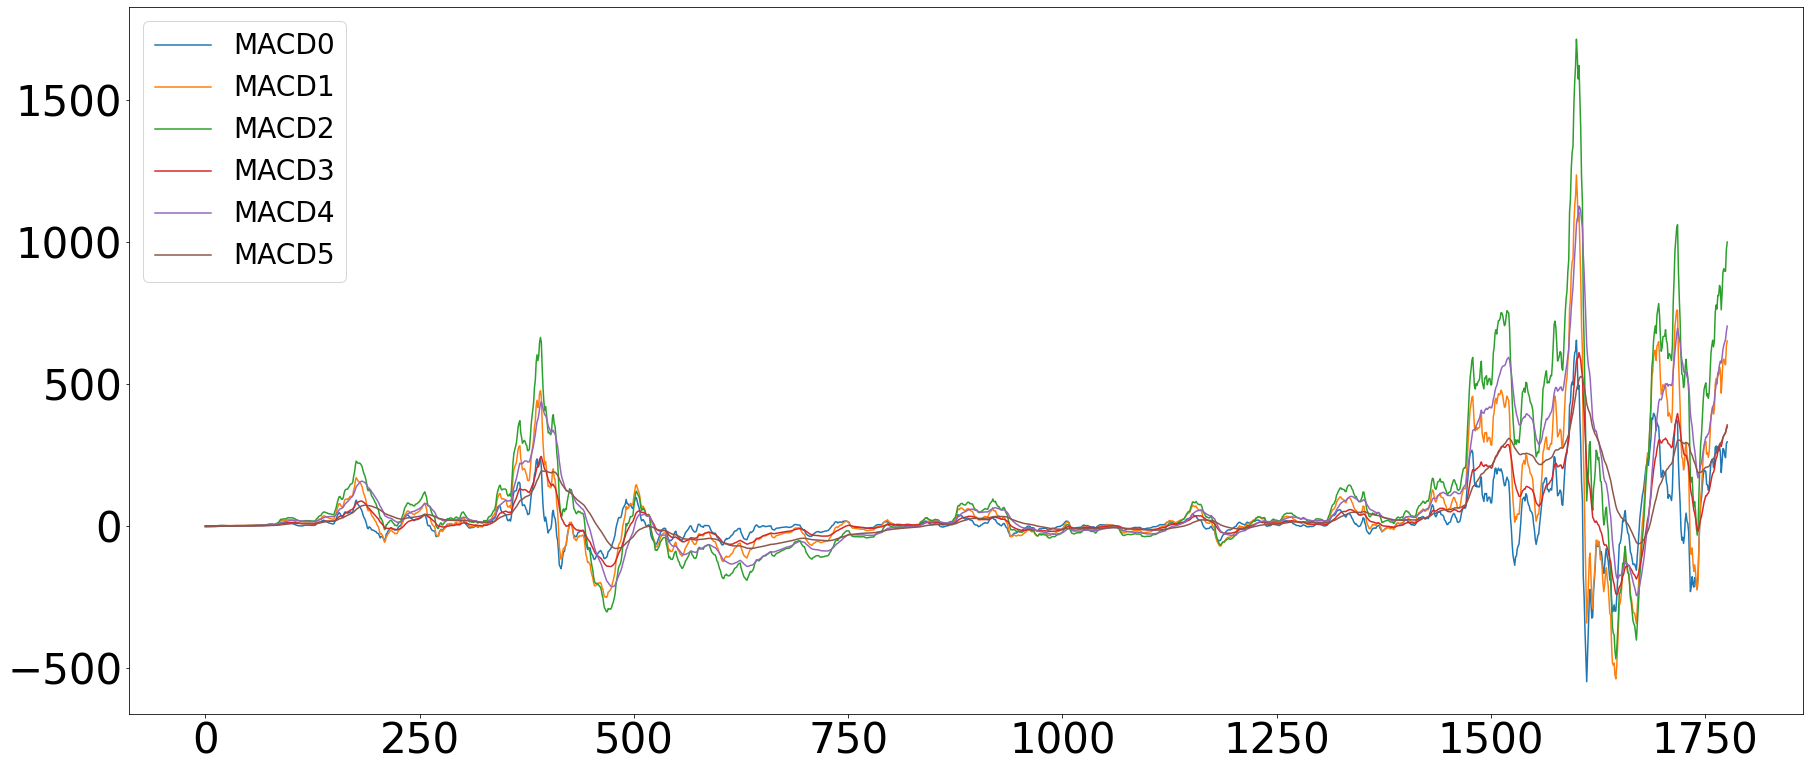

In [ ]:
MACD0 = np.array(EMA5) - np.array(EMA20)
MACD1 = np.array(EMA5) - np.array(EMA50)
MACD2 = np.array(EMA5) - np.array(EMA100)
MACD3 = np.array(EMA20) - np.array(EMA50)
MACD4 = np.array(EMA20) - np.array(EMA100)
MACD5 = np.array(EMA50) - np.array(EMA100)
plt.figure(figsize = (30,13))
plt.plot(list(range(full_len -500)), MACD0 ,label = 'MACD0')
plt.plot(list(range(full_len -500)), MACD1 ,label = 'MACD1')
plt.plot(list(range(full_len -500)), MACD2 ,label = 'MACD2')
plt.plot(list(range(full_len -500)), MACD3 ,label = 'MACD3')
plt.plot(list(range(full_len -500)), MACD4 ,label = 'MACD4')
plt.plot(list(range(full_len -500)), MACD5 ,label = 'MACD5')
plt.legend(fontsize = 28)



In [ ]:
band_up = np.array(MA20) + 2*np.array(STD20)
band_low = np.array(MA20) - 2*np.array(STD20)

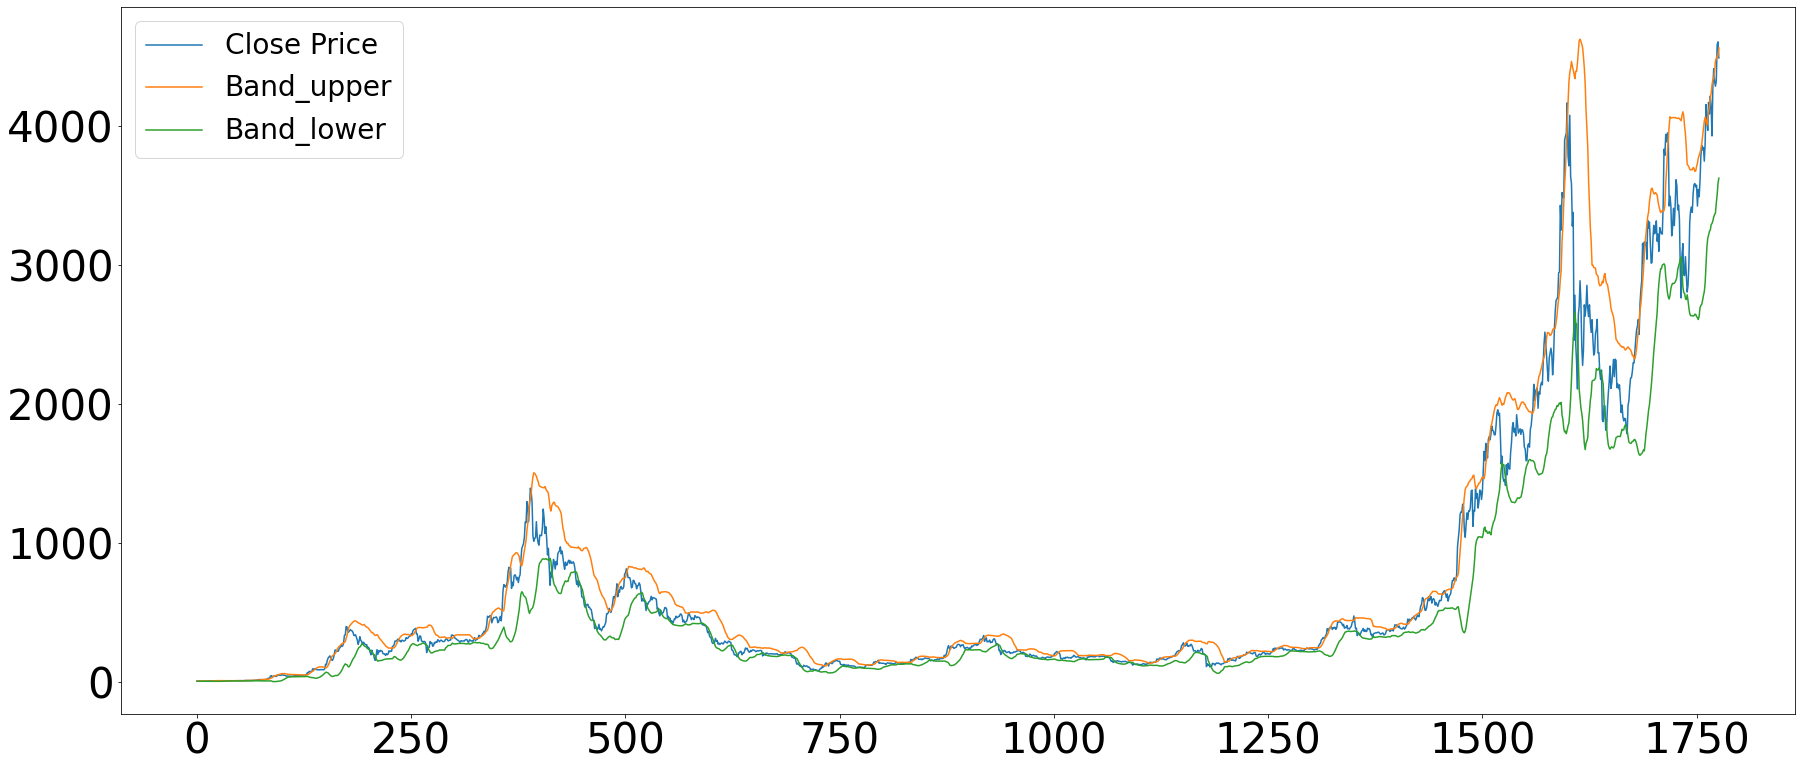

In [ ]:
plt.figure(figsize = (30,13))
plt.plot(list(range(full_len -500)), MA_data,label = 'Close Price')
plt.plot(list(range(full_len -500)), band_up ,label = 'Band_upper')
plt.plot(list(range(full_len -500)), band_low ,label = 'Band_lower')
plt.legend(fontsize = 28)

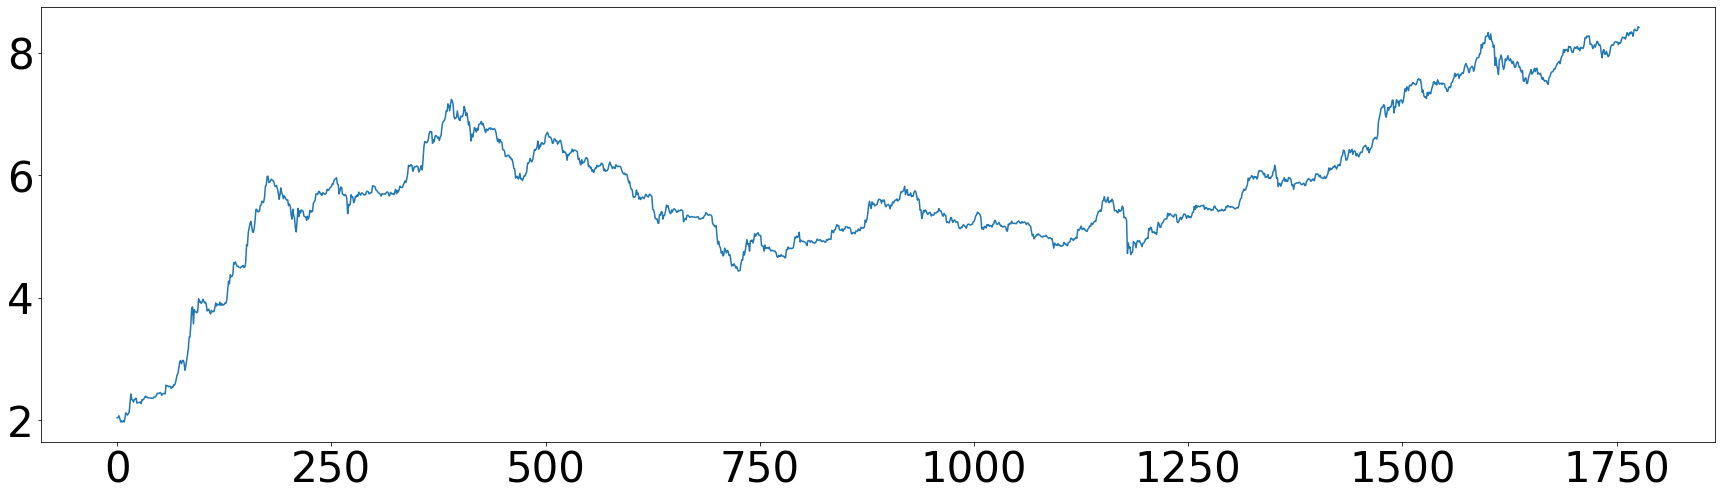

In [ ]:
log_close_price = np.log(log_market_data[500:,0])
plt.figure(figsize=(30,8))
plt.plot(list(range(full_len - 500)), log_close_price)

In [ ]:
# Using HMM to predict optimal sequence of hidden state

likelihood_vect = np.empty([0,1])
aic_vect = np.empty([0,1])
bic_vect = np.empty([0,1])
STATE_SPACE = range(2,20)
NUM_ITERS = 10000
dataset = MA_data[num_val:num_val+num_train]
dataset = np.reshape(dataset, (-1,1))

In [ ]:
for states in STATE_SPACE:
    num_params = states**2 + states
    dirichlet_params_states = np.random.randint(1,50,states)
    #model = hmm.GaussianHMM(n_components=states, covariance_type='full', startprob_prior=dirichlet_params_states, transmat_prior=dirichlet_params_states, tol=0.0001, n_iter=NUM_ITERS, init_params='mc')
    model = hmm.GaussianHMM(n_components=states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS)
    model.fit(dataset)
    
    if model.monitor_.iter == NUM_ITERS:
        print('Increase number of iterations')
        sys.exit(1)
    likelihood_vect = np.vstack((likelihood_vect, model.score(dataset)))
    aic_vect = np.vstack((aic_vect, -2 * model.score(dataset) + 2 * num_params))
    bic_vect = np.vstack((bic_vect, -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])))

opt_states = np.argmin(bic_vect) + 2
print('Optimum number of states are {}'.format(opt_states))

Optimum number of states are 9


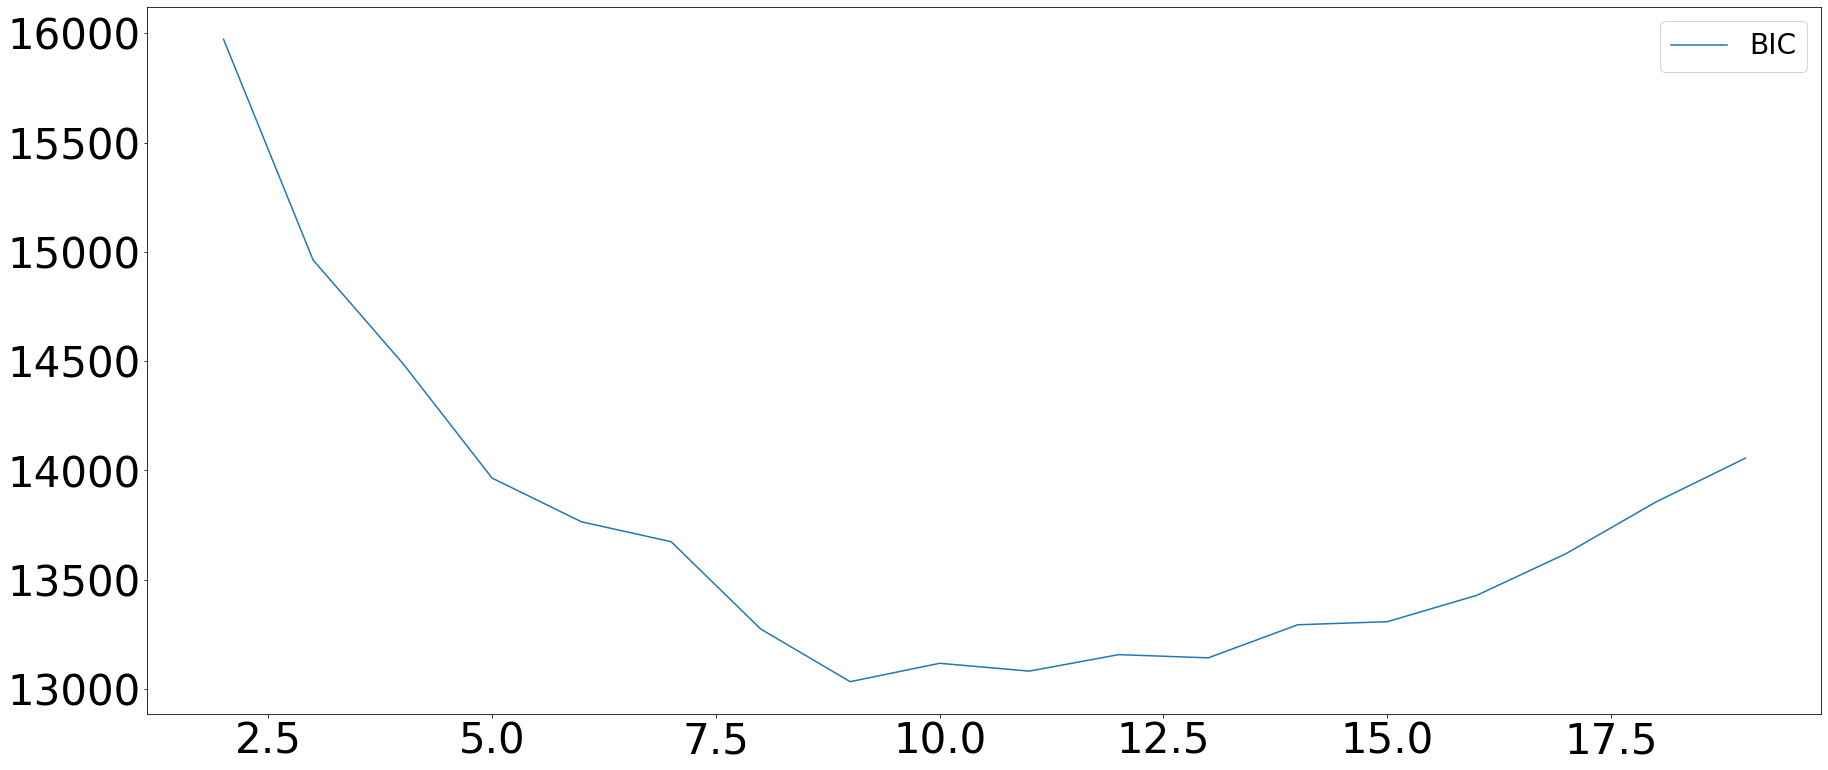

In [ ]:
plt.figure(figsize=(30,13))
plt.plot(STATE_SPACE, bic_vect, label = "BIC")
plt.legend(fontsize = 28)

In [ ]:
model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', n_iter=1000)
model.fit(np.reshape(MA_data,(-1,1)))

GaussianHMM(covariance_type='full', n_components=9, n_iter=1000)

In [ ]:
range_color = ['brown','red','deeppink','violet','aqua','gold','blue','orangered','purple','lawngreen','dodgerblue','lightcoral','lime','black']
hid_state = model.predict(np.reshape(MA_data,(-1,1)),full_len - num_subtract)
state_color = list(range(num_train+num_val))
for i in range(num_val+num_train):
  state_color[i] = range_color[hid_state[i]]
  #print(range_color[hid_state[i]])




In [ ]:
print(hid_state)

[3 3 3 ... 7 7 7]


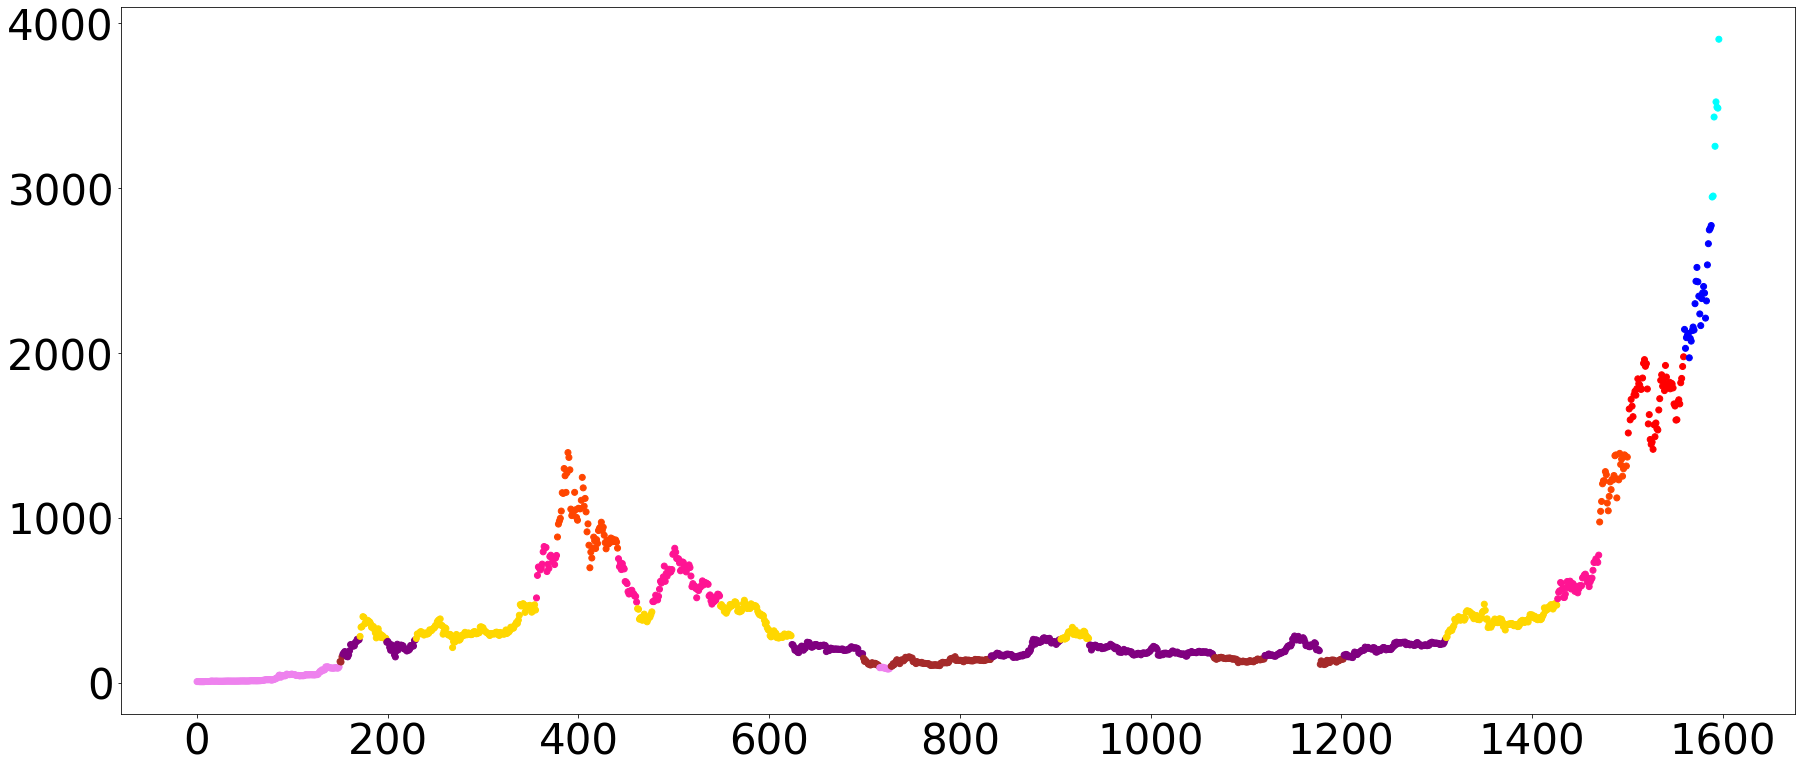

In [ ]:

plt.figure(figsize = (30,13))
x_range = list(range(num_train+num_val))
# print(x_range)
plt.scatter(x_range, MA_data[:num_val+num_train], color = state_color )
# plt.scatter([1,5,3],[5,15,35], color = ['aqua','navy','violet'])

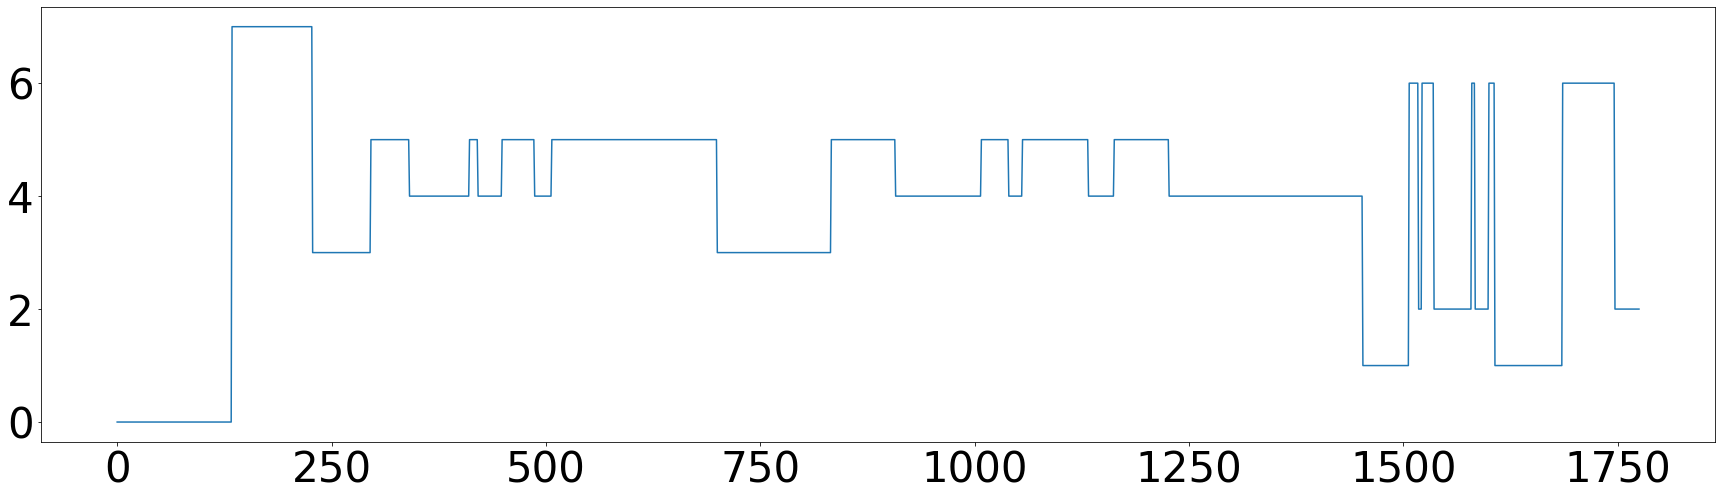

In [ ]:
plt.figure(figsize=(30,8))
plt.plot(hid_state)

In [ ]:
#hid_state = hid_state.reshape(-1,1)
print(hid_state.shape)
#hid_state = sc.fit_transform(hid_state)

(1777,)


In [ ]:
X = np.random.rand(full_len - num_subtract,9)
#------------Market Data----------
X[:,0] = log_market_data[500:,3]
X[:,1:4] = log_market_data[500:,0:3]
X[:,4:6] = volum_change
X[:,6] = log_market_data[500:,1] - log_market_data[500:,2]
X[:,7] = hid_state

#Technical Indicator Feature
#-----Moving Average-------------
# X[:,8] = MA5
# X[:,9] = MA20
# X[:,10] = MA50
# X[:,11] = MA100
#--------Standard Deviation------
# X[:,12] = STD5
# X[:,13] = STD20
# X[:,14] = STD50
# X[:,15] = STD100
#-------Exponential Moving Average---
# X[:,16] = EMA5
# X[:,17] = EMA20
# X[:,18] = EMA50
# X[:,19] = EMA100
#------------Moving Average Covergence Divergence--------
X[:,8] = MACD1
# X[:,21] = MACD1
# X[:,22] = MACD2
# X[:,23] = MACD3
# X[:,24] = MACD4
# X[:,25] = MACD5
#---------Boillinger Bands-----------------
# X[:,26] = band_up
# X[:,27] = band_low
#---------Log Close Price----------
# X[:,13] = log_close_price

In [ ]:
plt.figure(figsize= (30,13))
plt.plot(volum_change[:,0])

In [ ]:
a = band_low
print("Min = ", np.amin(a))
print("Max = ", np.amax(a))
print("Mean = ", np.mean(a))
print("Std = ", np.std(a))

Min =  697.3511573563882
Max =  57204.97644952824
Mean =  11725.142733837192
Std =  13012.84113655605


In [ ]:
print(a)

[[792.247009]
 [792.247009]
 [792.247009]
 ...
 [792.247009]
 [792.247009]
 [792.247009]]


In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
sc_prc = MinMaxScaler(feature_range=(0,1))


In [ ]:
X[:,0:1] = sc_prc.fit_transform(X[:,0:1])
X[:,1:] = sc.fit_transform(X[:,1:])

In [ ]:
X_train = X[num_val:num_val+num_train,:]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = X[num_val+1:num_val+num_train +1, 0:1]

In [ ]:
X_val = X[:num_val,:]
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
y_val = X[1:num_val+1, 0:1]

In [ ]:
X_test = X[num_val+num_train:num_val+num_train+num_test,:]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = sc_prc.inverse_transform(X[:,0:1])[num_val+num_train:]

In [ ]:
LSTM_model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
LSTM_model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True))
LSTM_model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True))
LSTM_model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50))
LSTM_model.add(Dropout(0.2))
# Adding the output layer
LSTM_model.add(Dense(units = 1))
# Compiling the RNN
LSTM_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
LSTM_model.summary()

In [ ]:
LSTM_model.fit(X_train, y_train, epochs=1, batch_size=100, validation_data=(X_val,y_val))

13/13 [==============================] - 0s 26ms/step - loss: 3.3310e-04 - val_loss: 3.1928e-05


In [ ]:
LSTM_model.save('HMM_LSTM_final.h5')

In [ ]:
LSTM_model.load_weights('HMM_LSTM_final.h5')

In [ ]:
X_total = X[:full_len - 201,:]
X_total = np.reshape(X_total, (X_total.shape[0],X_total.shape[1], 1))

In [ ]:
predict_price = LSTM_model.predict(X_test)
print(predict_price.shape)
predict_price = sc_prc.inverse_transform(predict_price)

# predict_price = sc.inverse_transform(predict_price)

# predict_price = np.exp(predict_price)
# real_price = np.exp(y_test)
# real_price = sc_prc.inverse_transform(y_train)

real_price = y_test

(180, 1)


In [ ]:
print(predict_price)

In [ ]:
print('predict ',predict_price.shape[0], 'real ',real_price.shape[0])

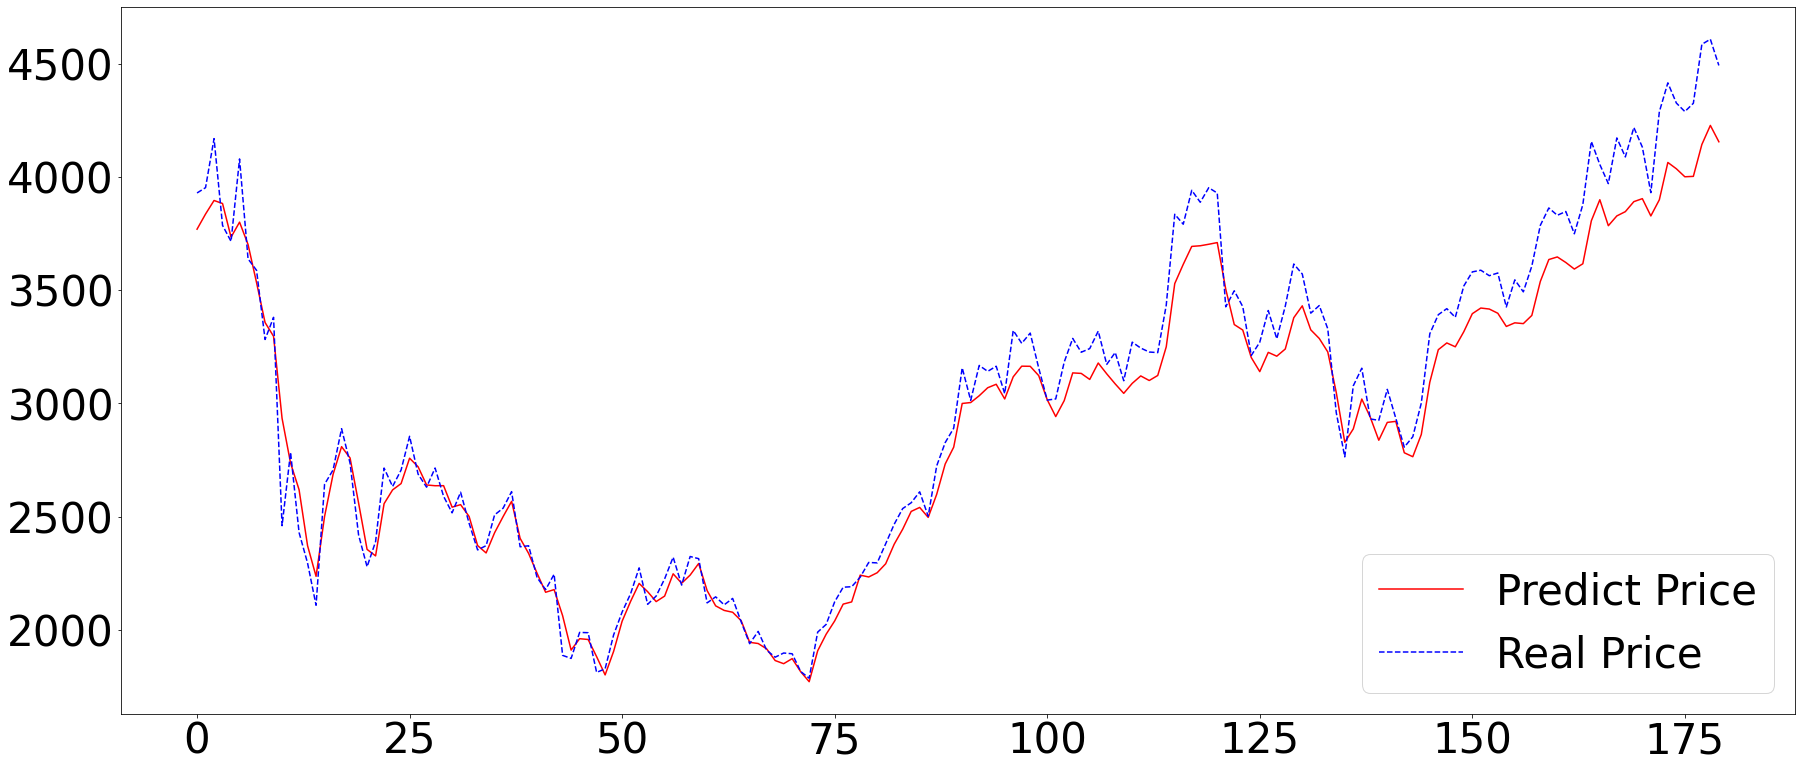

In [ ]:
plt.figure(figsize=(30,13))
plt.plot(list(range(180)),predict_price, 'r', label = 'Predict Price')
plt.plot(list(range(180)),real_price, 'b--', label = 'Real Price')
plt.legend()

In [ ]:
MAPE = np.abs(predict_price - real_price)
RMSE = np.multiply(MAPE,MAPE)
RMSE = math.sqrt(np.mean(RMSE))/np.mean(real_price)
MAE = np.mean(MAPE)/np.mean(real_price)
MAPE = np.divide(MAPE,real_price)
MAPE = np.mean(MAPE)
print('MAPE = ',MAPE)
print('MAE = ', MAE*100, '%')
print('RMSE = ',RMSE*100, '%')

MAPE =  0.02179387608777603
MAE =  2.3949088789700297 %
RMSE =  3.6496187499146404 %
